In [1]:
#!pip install psycopg2

In [2]:
#!pip install python-dotenv

In [3]:
#!pip install touch

In [31]:
import pandas as pd
from sqlalchemy import create_engine
import psycopg2
import os
import sys
#https://stackoverflow.com/questions/40216311/reading-in-environment-variables-from-an-environment-file
from dotenv import load_dotenv
load_dotenv()
import touch
import time
import plotly.offline as py
import plotly.graph_objects as go
pd.set_option('display.max_rows', 100000000000)

In [2]:
#create env file goto home dir and add user and password only once
#touch.touch('.env')

# Config params for postgres databse connection and test connection

In [3]:
#making conenction to postgresSQL DB
pgpassword = os.getenv('password')
pguser = os.getenv('user')
host =  'postgis1-s.bii.virginia.edu'
database = 'sdad'
#port = 

#trying connection
dbserver_p = psycopg2.connect(
    user=pguser, 
    password=pgpassword, 
    host=host,
    database=database 
)

#dbserver_p.autocommit = True
cursor_p = dbserver_p.cursor()


### Connect to the database and create engine

In [4]:
engine_p = create_engine("postgresql+psycopg2://{user}:{pw}@{host}/{db}"
                       .format(user=pguser, pw=pgpassword, host=host, db=database))

# Reusable code for converting database rows to dataframes

In [5]:
# Take in a PostgreSQL engine and query and return dataframe
def load_db_table(query, eng):
    '''
    Function which will use connection engine with pd.read_sql_query
    '''
    data = pd.read_sql_query(query, con=eng)
    return data

In [6]:
def load_tbl_cur(query, cursor):
    '''
    Function which will use cursor and fetch all the rows
    from result of sql query and convert to pandas dataframe
    '''
    cursor.execute(query)
    df = cursor.fetchall()
    colnames = [x[0] for x in cursor.description]
    return pd.DataFrame(df, columns=colnames)

### Queries to verify contributors tables created by joins 

In [7]:
myquery = """
        select *
        from gh.commits_pypi_112021 --oss gh commits table
        LIMIT 50
"""
df_tbl = load_db_table(myquery,engine_p)

In [8]:
df_tbl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   slug            50 non-null     object
 1   committed_date  50 non-null     object
 2   login           50 non-null     object
 3   additions       50 non-null     int64 
 4   deletions       50 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.1+ KB


# query the edgelist abel and save as a csv
* download NetwrokX and run statistics

In [9]:
myquery_el = """
        select *
        from gh.sna_pypi_edgelist_wisos_0819 --edgelist created
        --limit 100
"""
df_tbl_el = load_db_table(myquery_el,engine_p)

In [10]:
df_tbl_el.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944064 entries, 0 to 944063
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   ctr1      944064 non-null  object
 1   ctr2      944064 non-null  object
 2   repo_wts  944064 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 21.6+ MB


In [11]:
df_tbl_el.to_csv('/project/class/sds_sdad/oss_capstone2021-2022/clean_data_11132021/pypi_contrib_edgelist.csv')

In [19]:
df_tbl_el_small = df_tbl_el.sample(1000)

In [12]:
#! pip install networkx

In [13]:
import networkx as nx
import operator

In [62]:
#https://stackoverflow.com/questions/42558165/load-nodes-with-attributes-and-edges-from-dataframe-to-networkx
G = nx.from_pandas_edgelist(df_tbl_el_small, 'ctr1', 'ctr2', 'repo_wts')

In [63]:
#https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python
#prints graph info
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1796
Number of edges: 1000
Average degree:   1.1136


In [22]:
density = nx.density(G)
print("Network density:", density)

Network density: 0.0006203820312548467


In [23]:
#centrality
#https://stackoverflow.com/questions/18595686/how-do-operator-itemgetter-and-sort-work
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')
sorted_degree = sorted(degree_dict.items(), key=operator.itemgetter(1), reverse=True)
print("Top 20 nodes by degree:")
for d in sorted_degree[:20]:
    print(d)

Top 20 nodes by degree:
('dependabot-preview[bot]', 6)
('dependabot[bot]', 4)
('rovere', 3)
('marinakolosova', 3)
('matz-e', 3)
('ftorresd', 3)
('skottmckay', 3)
('mulhearn', 3)
('malbouis', 3)
('adewit', 3)
('dstufft', 3)
('ralphbean', 3)
('bochecha', 3)
('oleksiyskononenko', 3)
('justacec', 3)
('JelleZijlstra', 3)
('anntzer', 3)
('butla', 2)
('REVIMI', 2)
('gaftech', 2)


In [24]:
betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality

# Assign each to an attribute in your network
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

In [25]:
sorted_betweenness = sorted(betweenness_dict.items(), key=operator.itemgetter(1), reverse=True)

print("Top 20 nodes by betweenness centrality:")
for b in sorted_betweenness[:20]:
    print(b)

Top 20 nodes by betweenness centrality:
('ftorresd', 2.9190461550883013e-05)
('silviodonato', 1.98743568006012e-05)
('malbouis', 1.8011135850544837e-05)
('fgolf', 1.6768988550507264e-05)
('marinakolosova', 1.3042546650394538e-05)
('matz-e', 1.3042546650394538e-05)
('dependabot-preview[bot]', 1.242147300037575e-05)
('amartelli', 6.831810150206663e-06)
('dependabot[bot]', 5.589662850169088e-06)
('adewit', 4.9685892001503e-06)
('Ablinne', 3.7264419001127252e-06)
('mulhearn', 3.1053682500939374e-06)
('bochecha', 3.1053682500939374e-06)
('JelleZijlstra', 3.1053682500939374e-06)
('mkiani', 2.48429460007515e-06)
('d-salerno', 2.48429460007515e-06)
('slava77', 2.48429460007515e-06)
('bollwyvl', 2.48429460007515e-06)
('kammala', 2.48429460007515e-06)
('gartung', 2.48429460007515e-06)


In [26]:
triadic_closure = nx.transitivity(G)
print("Triadic closure:", triadic_closure)

Triadic closure: 0


In [35]:
#https://towardsdatascience.com/tutorial-network-visualization-basics-with-networkx-and-plotly-and-a-little-nlp-57c9bbb55bb9
#https://plotly.com/python/network-graphs/

In [29]:
#https://deparkes.co.uk/2018/04/02/python-simple-networkx-example/
#https://networkx.org/documentation/networkx-2.3/tutorial.html
#nx.draw(G, with_labels=True, font_weight='bold')
#https://www.cl.cam.ac.uk/~cm542/teaching/2010/stna-pdfs/stna-lecture8.pdf
#https://bl.ocks.org/mbostock/1044242
#https://www.python-graph-gallery.com/323-directed-or-undirected-network

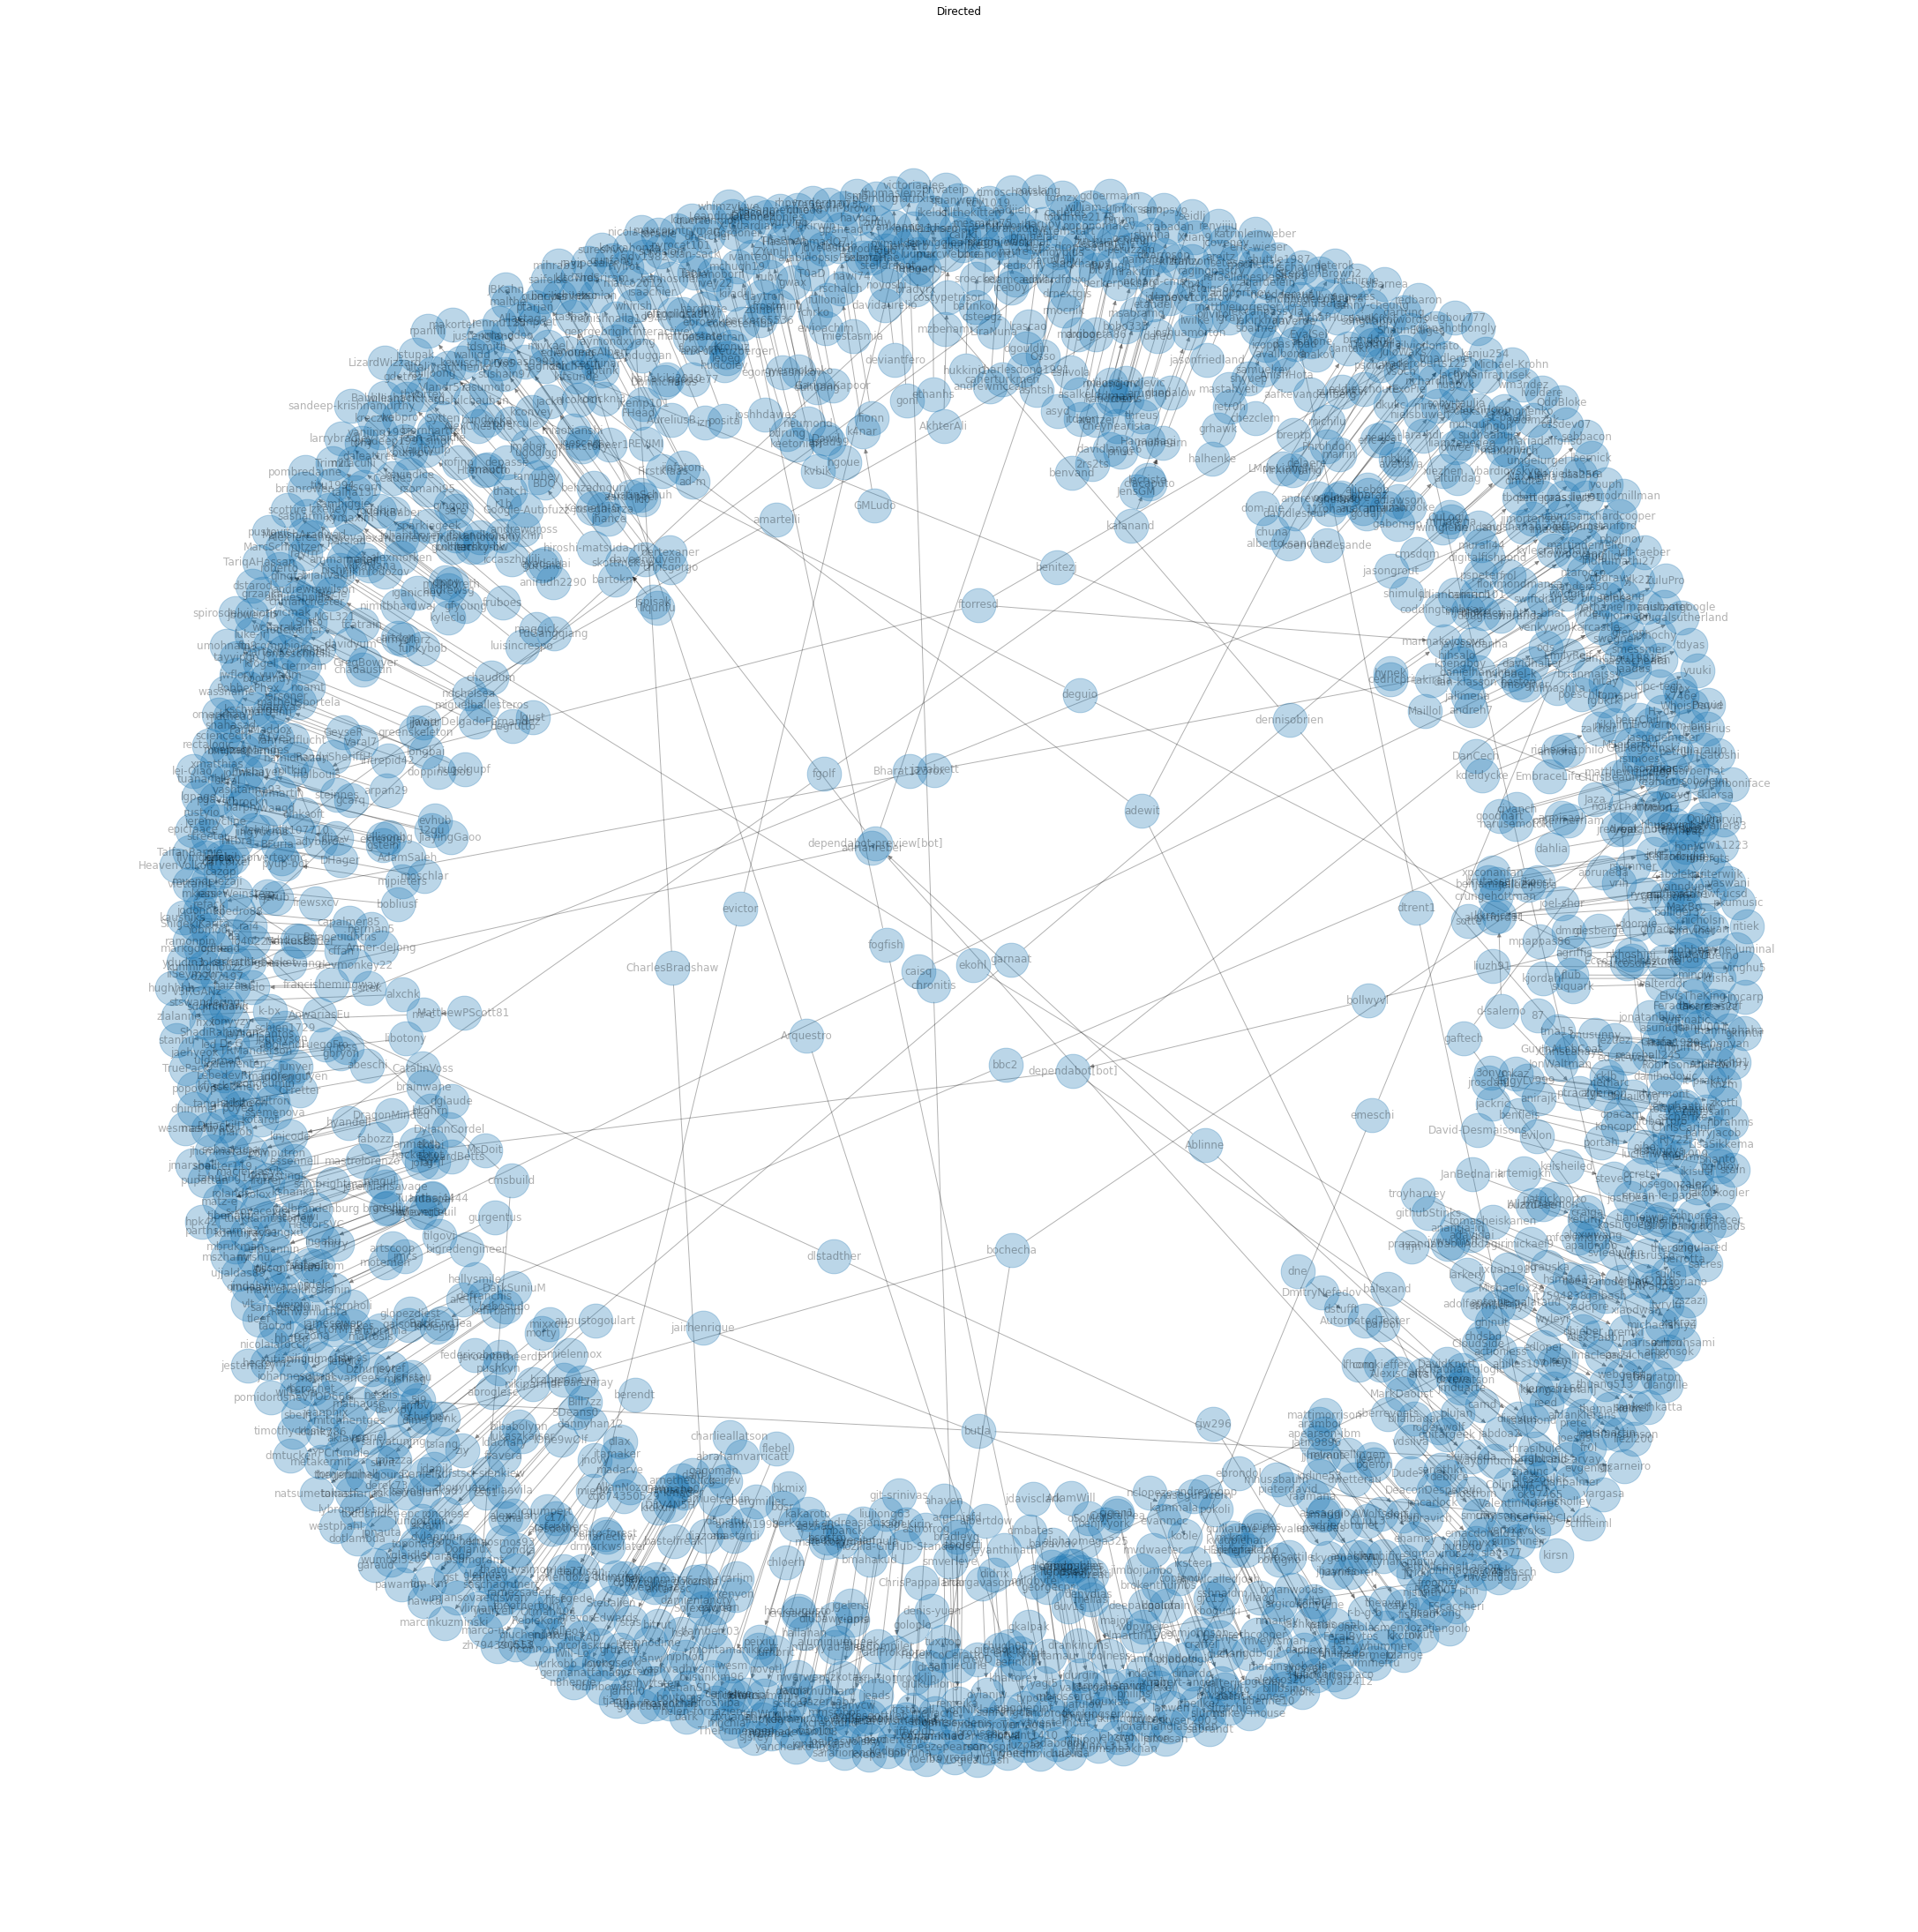

In [89]:
figure(figsize=(30,30)) 
#https://www.python-graph-gallery.com/323-directed-or-undirected-network
# Build your graph. Note that we use the DiGraph function to create the graph!
G_test=nx.from_pandas_edgelist(df_tbl_el_small, 'ctr1', 'ctr2', create_using=nx.DiGraph() )
# Make the graph
nx.draw(G_test, with_labels=True, node_size=1500, alpha=0.3, arrows=True)
plt.title("Directed")
plt.savefig('take1_1000sample.png')
plt.show()

In [86]:
#https://towardsdatascience.com/from-dataframe-to-network-graph-bbb35c8ab675
#from matplotlib.pyplot import figure
#plt.figure(figsize=(25,25))
#nx.draw_shell(G_test, with_labels=True)

{}

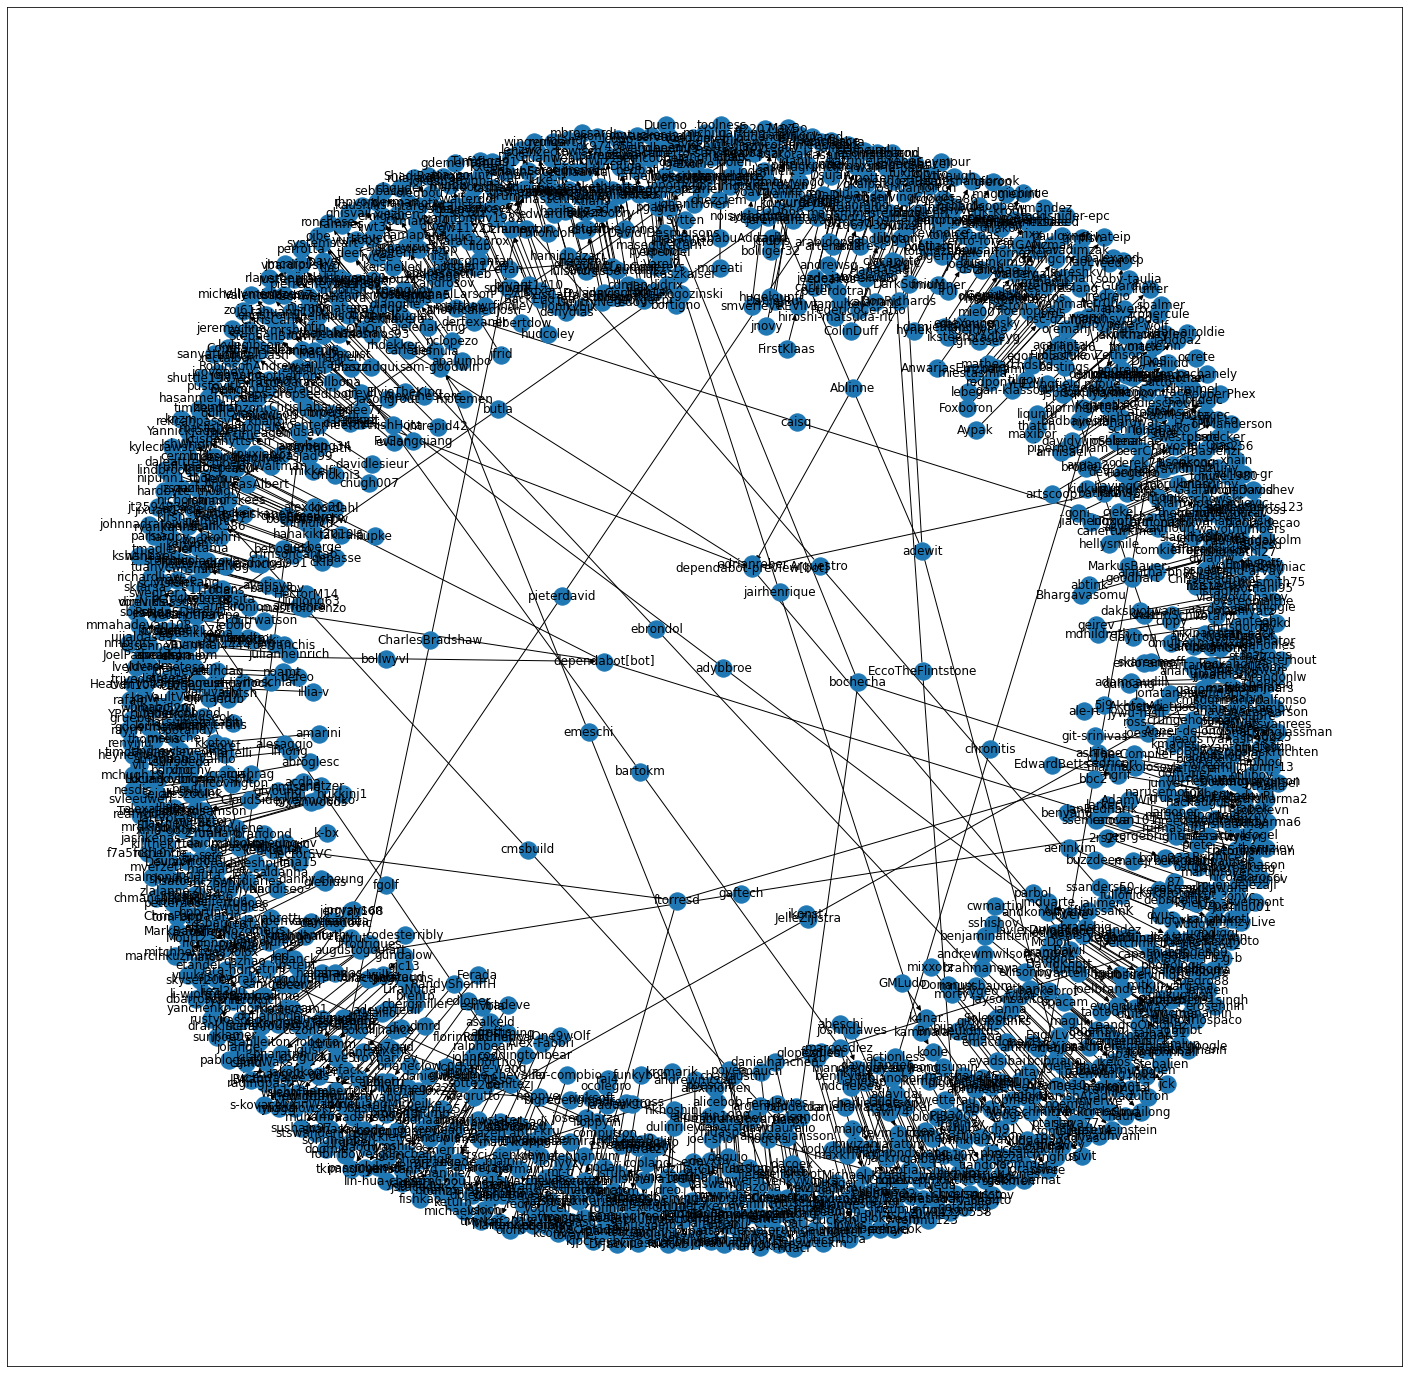

In [77]:
#https://stackoverflow.com/questions/28372127/add-edge-weights-to-plot-output-in-networkx
pos=nx.spring_layout(G_test) # pos = nx.nx_agraph.graphviz_layout(G)
plt.figure(figsize=(25,25))
nx.draw_networkx(G_test,pos)
labels = nx.get_edge_attributes(G_test,'repo_wts')
nx.draw_networkx_edge_labels(G_test,pos,edge_labels=labels)